<a id='Top'></a>

# Unimodal inputs<a class='tocSkip'></a>

Evaluation metric results for MultiSurv with unimodal data inputs compared with baseline models.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os
import copy

from IPython.display import clear_output
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Input-data" data-toc-modified-id="Input-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Input data</a></span></li><li><span><a href="#Dimensionality-reduction" data-toc-modified-id="Dimensionality-reduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dimensionality reduction</a></span></li><li><span><a href="#Tune-models" data-toc-modified-id="Tune-models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tune models</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluate</a></span><ul class="toc-item"><li><span><a href="#Write-to-results-table" data-toc-modified-id="Write-to-results-table-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Write to results table</a></span></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR

## Functions<a class='tocSkip'></a>

In [3]:
def dataset_to_df(pytorch_dataset, modality):   
    data_dict = {'time': [],
                 'event': [],
                 'patient_id': []}
    
    n_vars = {
#         'clinical': 15,
        'clinical': 10,
        'mRNA': 1000,
        'miRNA': 1881,
        'DNAm': 5000,
        'CNV': 2000
    }

    for i in range(n_vars[modality]):
        data_dict[str(i)] = []
    
    for i, patient_data in enumerate(pytorch_dataset):
        data, time, event, pid = patient_data
        print('\r' + f'Load all patient data: {str((i + 1))}/{len(pytorch_dataset)}    ',
              end='')
        
        data_dict['time'].append(time)
        data_dict['event'].append(event)
        data_dict['patient_id'].append(pid)
        
        if modality == 'clinical':
            for j, x in enumerate(data[modality][0]):
                data_dict[str(j)].append(int(x))

            for x in data[modality][1]:
                j += 1
                data_dict[str(j)].append(round(float(x), 6))
        elif modality == 'CNV':
            for j, x in enumerate(data[modality]):
                data_dict[str(j)].append(int(x))
        else:
            for j, x in enumerate(data[modality]):
                data_dict[str(j)].append(round(float(x), 6))
    print()
            
    df = pd.DataFrame.from_dict(data_dict)
    df.set_index('patient_id', inplace=True)
    
    return df

# Input data

In [4]:
modality = widgets.Select(
    options=['clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV'],
    index=0,
    rows=5,
    description='Input data',
    disabled=False
)
display(modality)

Select(description='Input data', options=('clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV'), value='clinical')

In [5]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=[modality.value],
#     wsi_patch_size=299,
#     n_wsi_patches=5,
    batch_size=256,
#     exclude_patients=exclude_cancers
    return_patient_id=True
)

Excluding 615 patient(s) missing all data.
Excluding 72 patient(s) missing all data.
Excluding 69 patient(s) missing all data.
Data modalities:
   CNV

Dataset sizes (# patients):
   train: 8265
   val: 1037
   test: 1023

Batch size: 256


In [6]:
%%time

data_groups = ['train', 'val', 'test']

data_dfs = {
    x: dataset_to_df(pytorch_dataset=dataloaders[x].dataset,
                     modality=modality.value)
    for x in data_groups
}

print()
print()

Load all patient data: 8265/8265    
Load all patient data: 1037/1037    
Load all patient data: 1023/1023    


CPU times: user 3min 53s, sys: 43.9 s, total: 4min 36s
Wall time: 10min 23s


In [7]:
# One-hot encode categorical variables (present in clinical and CNV data)
if modality.value in ['clinical', 'CNV']:
    if modality.value == 'clinical':
#         cols = [str(x) for x in range(14)]
        cols = [str(x) for x in range(9)]
    elif modality.value == 'CNV':
        cols = data_dfs['train'].columns[2:]

    # Convert index to regular column
    for group in data_groups:
        data_dfs[group].reset_index(level=['patient_id'], inplace=True)
        
    temp = pd.get_dummies(
        pd.concat([data_dfs['train'], data_dfs['val'], data_dfs['test']], keys=[0, 1, 2]),
        columns=cols, drop_first=True)
    data_dfs['train'], data_dfs['val'], data_dfs['test'] = temp.xs(0), temp.xs(1), temp.xs(2)
    
    # Put index back
    for group in data_groups:
        data_dfs[group].set_index('patient_id', inplace=True)

In [8]:
data_dfs['train'].shape

(8265, 4002)

In [9]:
data_dfs['val'].shape

(1037, 4002)

In [10]:
data_dfs['test'].shape

(1023, 4002)

In [11]:
data_dfs['test'].head(3)

,time,event,0_1,0_2,1_1,1_2,2_1,2_2,3_1,3_2,...,1995_1,1995_2,1996_1,1996_2,1997_1,1997_2,1998_1,1998_2,1999_1,1999_2
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-CQ-6224,4.715068,0,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
TCGA-AA-3947,2.750685,0,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
TCGA-ER-A19K,1.284932,1,1,0,1,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0


# Dimensionality reduction

Reduce dimensions to speed up classical algorithms.

In [12]:
def reduce_dim(train, val, test, n):
    pca = PCA(n_components=n)
    pca.fit(train)
    
    train = pca.transform(train)
    val = pca.transform(val)
    test = pca.transform(test)
    
    return train, val, test

if modality.value != 'clinical':  # 52 variables only
    pca = copy.deepcopy(data_dfs)

    # Get components
    pca['train'], pca['val'], pca['test'] = reduce_dim(
        data_dfs['train'].iloc[:, 2:],
        data_dfs['val'].iloc[:, 2:],
        data_dfs['test'].iloc[:, 2:], 50)

    # Add labels back
    for group in data_groups:
        pca[group] = pd.concat(
            [data_dfs[group].iloc[:, :2],
             pd.DataFrame(pca[group]).set_index(data_dfs[group].index)], axis=1)

# Tune models

* CPH ([Cox, 1972](https://www.jstor.org/stable/2985181?seq=1));
* RSF ([Ishwaran *et al.*, 2008](https://arxiv.org/abs/0811.1645));
* DeepSurv ([Katzman *et al.*, 2018](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1));
* CoxTime ([Kvamme *et al.*, 2019](http://jmlr.org/papers/volume20/18-424/18-424.pdf));
* DeepHit ([Lee *et al.*, 2018](http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit));
* MTLR ([Fotso, 2018](https://arxiv.org/abs/1801.05512));
* Nnet-survival ([Gensheimer and Narasimhan, 2019](https://peerj.com/articles/6257/); [Kvamme and Borgan, 2019](https://arxiv.org/abs/1910.06724)).

In [13]:
pycox_methods = ['DeepSurv', 'CoxTime', 'DeepHit', 'MTLR', 'Nnet-survival']
methods = ['CPH', 'RSF'] + pycox_methods

algorithm = widgets.Select(
    options=methods,
    index=0,
    rows=len(methods),
    description='Input data',
    disabled=False
)
display(algorithm)

Select(description='Input data', options=('CPH', 'RSF', 'DeepSurv', 'CoxTime', 'DeepHit', 'MTLR', 'Nnet-surviv…

In [90]:
def prepare_data(data, modality, algorithm):
    data = data_dfs  # full data
    description = f'full {modality} data'

    if algorithm in ['CPH', 'RSF']:
        if modality != 'clinical':
            data = pca # PCA-decomposed data
            description = f'reduced {modality} data (PCA)'
    return data, description

In [91]:
# Get data
data, data_name = prepare_data(data_dfs, modality=modality.value, algorithm=algorithm.value)

In [100]:
# Fit model
print(f'Fitting {algorithm.value} model on {data_name}...')
print()

if algorithm.value == 'CPH':
    baseline = utils.Baselines(algorithm.value, data)
    baseline.fit(show_progress=False, step_size=1.0)
elif algorithm.value == 'RSF':
    baseline = utils.Baselines(algorithm.value, data, n_trees=50)
    baseline.fit()
elif algorithm.value in pycox_methods:
#     n_neurons = [32, 32]
    n_neurons = [64, 32]
#     n_neurons = [128, 64]
#     n_neurons = [128, 64, 32]
    best_baseline = baseline
    baseline = utils.Baselines(algorithm.value, data, n_neurons=n_neurons)
    baseline.fit(batch_size=256, verbose=True)

Fitting Nnet-survival model on full CNV data...

   30 equidistant intervals
   Learning rate 4e-05
   Batch size 256

0:	[0s / 0s],		train_loss: 2.4735,	val_loss: 2.4967
1:	[0s / 0s],		train_loss: 2.4262,	val_loss: 2.4876
2:	[0s / 0s],		train_loss: 2.3996,	val_loss: 2.5164
3:	[0s / 0s],		train_loss: 2.3856,	val_loss: 2.4847
4:	[0s / 1s],		train_loss: 2.3662,	val_loss: 2.4772
5:	[0s / 1s],		train_loss: 2.3686,	val_loss: 2.5191
6:	[0s / 1s],		train_loss: 2.3450,	val_loss: 2.4485
7:	[0s / 1s],		train_loss: 2.3333,	val_loss: 2.4122
8:	[0s / 2s],		train_loss: 2.3269,	val_loss: 2.4549
9:	[0s / 2s],		train_loss: 2.3146,	val_loss: 2.4325
10:	[0s / 2s],		train_loss: 2.3031,	val_loss: 2.4992
11:	[0s / 2s],		train_loss: 2.2919,	val_loss: 2.4182
12:	[0s / 2s],		train_loss: 2.2857,	val_loss: 2.4072
13:	[0s / 3s],		train_loss: 2.2749,	val_loss: 2.4088
14:	[0s / 3s],		train_loss: 2.2693,	val_loss: 2.3791
15:	[0s / 3s],		train_loss: 2.2733,	val_loss: 2.4804
16:	[0s / 3s],		train_loss: 2.2467,	val_los

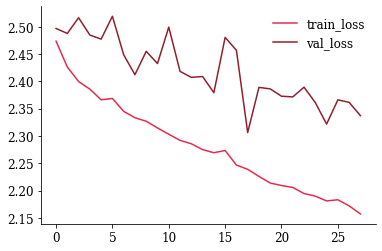

In [101]:
if algorithm.value in pycox_methods:
    _ = baseline.training_log.plot()
else:
    clear_output()

In [102]:
%%time

print(f'{algorithm.value} model fit on {data_name}...')
print()

check_results = {'train': None, 'val': None}

for group in check_results.keys():
    print(f'~ {group} ~')
    performance = utils.Evaluation(model=baseline.model, dataset=baseline.data[group])
    performance.compute_metrics()
    performance.show_results()
    print()

Nnet-survival model fit on full CNV data...

~ train ~
Collect patient predictions...

C-index   0.549
Ctd       0.568
IBS       0.34
INBLL     2.209

~ val ~
Collect patient predictions...

C-index   0.534
Ctd       0.547
IBS       0.383
INBLL     1.901

CPU times: user 6.77 s, sys: 215 ms, total: 6.99 s
Wall time: 4.1 s


In [103]:
%%time

print(f'{algorithm.value} model fit on {data_name}...')
print()

check_results = {'train': None, 'val': None}

for group in check_results.keys():
    print(f'~ {group} ~')
    performance = utils.Evaluation(model=best_baseline.model, dataset=best_baseline.data[group])
    performance.compute_metrics()
    performance.show_results()
    print()

Nnet-survival model fit on full CNV data...

~ train ~
Collect patient predictions...

C-index   0.59
Ctd       0.597
IBS       0.34
INBLL     2.158

~ val ~
Collect patient predictions...

C-index   0.581
Ctd       0.588
IBS       0.383
INBLL     1.899

CPU times: user 6.94 s, sys: 228 ms, total: 7.17 s
Wall time: 4.16 s


# Evaluate

In [104]:
%%time

baseline = best_baseline

performance = utils.Evaluation(model=baseline.model, dataset=baseline.data['test'])
performance.run_bootstrap(n=1000)
print()

Collect patient predictions...

Bootstrap
---------
1000/1000

CPU times: user 3min 5s, sys: 1.16 s, total: 3min 7s
Wall time: 2min 58s


In [105]:
print(f'>> {algorithm.value}: {modality.value} <<')
print()
performance.show_results()

>> Nnet-survival: CNV <<

          Value (95% CI)
-----------------------------
C-index   0.57 (0.544-0.594)
Ctd       0.575 (0.548-0.598)
IBS       0.401 (0.375-0.444)
INBLL     1.996 (1.702-2.169)


## Write to results table

In [106]:
results = utils.ResultTable()

In [107]:
results.write_result_dict(result_dict=performance.format_results(),
                          algorithm=algorithm.value,
                          data_modality=modality.value)
results.table

clinical                 mRNA  \
Algorithm     Metric                                              
CPH           C-index  0.796 (0.779-0.813)  0.733 (0.712-0.756)   
              Ctd      0.796 (0.779-0.813)  0.733 (0.712-0.755)   
              IBS      0.143 (0.135-0.154)   0.177 (0.165-0.19)   
              INBLL    0.438 (0.414-0.465)  0.528 (0.497-0.558)   
RSF           C-index  0.764 (0.744-0.782)  0.718 (0.695-0.741)   
              Ctd       0.77 (0.751-0.789)  0.719 (0.695-0.741)   
              IBS      0.184 (0.179-0.191)    0.191 (0.181-0.2)   
              INBLL     0.546 (0.533-0.56)  0.563 (0.537-0.581)   
DeepSurv      C-index  0.792 (0.773-0.811)  0.746 (0.722-0.768)   
              Ctd       0.792 (0.773-0.81)  0.746 (0.722-0.768)   
              IBS      0.143 (0.134-0.154)   0.18 (0.159-0.198)   
              INBLL    0.436 (0.412-0.464)   0.606 (0.513-0.68)   
CoxTime       C-index  0.789 (0.771-0.806)  0.731 (0.707-0.753)   
              Ctd        0.8 (0.783-0.817)  0.732 (0.708-0.755)   
              IBS      0.148 (0.139-0.159)  0.173 (0.159-0.185)   
              INBLL    0.448 (0.427-0.475)  0.524 (0.488-0.556)   
DeepHit       C-index   0.798 (0.78-0.815)   0.744 (0.72-0.767)   
              Ctd      0.809 (0.792-0.826)  0.752 (0.728-0.774)   
              IBS      0.173 (0.165-0.184)   0.191 (0.18-0.198)   
              INBLL    0.517 (0.499-0.542)  0.559 (0.532-0.575)   
MTLR          C-index  0.801 (0.782-0.821)   0.742 (0.72-0.764)   
              Ctd      0.806 (0.787-0.825)  0.745 (0.723-0.766)   
              IBS      0.147 (0.134-0.161)  0.178 (0.156-0.196)   
              INBLL     0.441 (0.41-0.478)  0.543 (0.472-0.598)   
Nnet-survival C-index  0.805 (0.787-0.822)   0.69 (0.662-0.718)   
              Ctd       0.81 (0.794-0.828)  0.701 (0.673-0.728)   
              IBS      0.132 (0.122-0.147)  0.195 (0.169-0.212)   
              INBLL     0.404 (0.38-0.443)  0.724 (0.597-0.832)   
MultiSurv     C-index   0.806 (0.79-0.823)  0.755 (0.733-0.777)   
              Ctd      0.809 (0.793-0.825)   0.758 (0.735-0.78)   
              IBS      0.143 (0.134-0.155)  0.178 (0.157-0.194)   
              INBLL    0.439 (0.416-0.469)  0.533 (0.475-0.577)   

                                      DNAm                miRNA  \
Algorithm     Metric                                              
CPH           C-index   0.739 (0.719-0.76)    0.676 (0.651-0.7)   
              Ctd       0.739 (0.719-0.76)    0.676 (0.651-0.7)   
              IBS      0.179 (0.165-0.192)  0.186 (0.171-0.202)   
              INBLL    0.532 (0.499-0.563)  0.547 (0.511-0.585)   
RSF           C-index  0.728 (0.707-0.751)  0.663 (0.638-0.688)   
              Ctd      0.729 (0.709-0.752)  0.664 (0.639-0.689)   
              IBS      0.186 (0.176-0.192)  0.193 (0.183-0.201)   
              INBLL     0.55 (0.527-0.564)  0.567 (0.543-0.583)   
DeepSurv      C-index     0.76 (0.74-0.78)  0.685 (0.661-0.711)   
              Ctd       0.759 (0.739-0.78)  0.685 (0.661-0.711)   
              IBS      0.177 (0.156-0.203)   0.194 (0.17-0.219)   
              INBLL    0.931 (0.684-1.132)   0.61 (0.527-0.689)   
CoxTime       C-index  0.747 (0.726-0.767)  0.692 (0.667-0.718)   
              Ctd      0.747 (0.726-0.767)    0.694 (0.67-0.72)   
              IBS      0.172 (0.156-0.191)  0.174 (0.158-0.189)   
              INBLL    0.519 (0.475-0.571)  0.521 (0.479-0.563)   
DeepHit       C-index  0.733 (0.712-0.754)  0.701 (0.675-0.724)   
              Ctd      0.737 (0.715-0.758)    0.7 (0.674-0.725)   
              IBS      0.194 (0.179-0.208)  0.186 (0.177-0.197)   
              INBLL    0.571 (0.529-0.605)  0.548 (0.524-0.575)   
MTLR          C-index   0.747 (0.726-0.77)  0.691 (0.664-0.717)   
              Ctd       0.751 (0.73-0.775)  0.693 (0.666-0.718)   
              IBS       0.176 (0.162-0.19)  0.192 (0.169-0.214)   
              INBLL    0.542 (0.504-0.584)  0.589 (0.515-0.657)   
Nnet-survival

# Watermark<a class='tocSkip'></a>

In [5]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

pandas     1.0.1
numpy      1.18.1
ipywidgets 7.5.1
matplotlib 3.1.2

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)